In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import mne
import mne.filter
from mne.time_frequency import psd_array_multitaper
%matplotlib inline

## Data loader

#### 3 experiments were conducted generating 7 files for each subject:
01. Speaking_interacting;
02. Speaking_alone;
03. Pong_Playing against each other;
04. Pong_Playing against PC;
05. CSGO_Playing against each other;
06. CSGO_Playing together against PC;
07. CSGO_Playing alone against PC;

#### It is necessary to compare subjects' brain activity in experiments:
- 01 vs 02
- 03 vs 04
- 05 vs 07
- 06 vs 07

In [2]:
# function get_data receives an array of size (2,) such as [3, 4]
# it loads data of experiments with the corresponding indices for both subjects and returns data matrices
# input: exps - an array of size (2,) such as [3, 4], which contrains indices of the experiments
#        root_data_folder - path of the folder, which contains mat files with preprocessed data
def get_data(exps, root_data_folder = 'HS_data_preprocessed/'):
    
    # list subject folders
    folders = os.listdir(root_data_folder)
    sub_folders = [root_data_folder + folders[i] + '/' for i in range(len(folders)) if folders[i] != '.DS_Store']
    
    # get files paths
    num_exp = 7
    sub1_file_paths, sub2_file_paths = np.sort(os.listdir(sub_folders[0])), np.sort(os.listdir(sub_folders[1]))
    sub1_file_paths = [sub_folders[0] + sub1_file_paths[i] for i in range(num_exp)]
    sub2_file_paths = [sub_folders[1] + sub2_file_paths[i] for i in range(num_exp)]
    sub_file_paths = [sub1_file_paths, sub2_file_paths]
    sub1_path, sub1_ref_path = sub_file_paths[0][exps[0]-1], sub_file_paths[0][exps[1]-1]
    sub2_path, sub2_ref_path = sub_file_paths[1][exps[0]-1], sub_file_paths[1][exps[1]-1]
    
    # loading data from mat files (preprocessed data)
    sub1_data, sub1_ref_data = sp.io.loadmat(sub1_path), sp.io.loadmat(sub1_ref_path)
    sub2_data, sub2_ref_data = sp.io.loadmat(sub2_path), sp.io.loadmat(sub2_ref_path)
    sub1_data, sub1_ref_data = sub1_data["EEG"][0][0][15], sub1_ref_data["EEG"][0][0][15]
    sub2_data, sub2_ref_data = sub2_data["EEG"][0][0][15], sub2_ref_data["EEG"][0][0][15]

    # cut data for each subject to have the same number of time samples in data matrices
    ts1, ts1_ref, ts2, ts2_ref = np.size(sub1_data, 1), np.size(sub1_ref_data, 1), np.size(sub2_data, 1), np.size(sub2_ref_data, 1)
    ts1_new, ts2_new = min(ts1, ts1_ref), min(ts2, ts2_ref)
    sub1_data, sub1_ref_data = sub1_data[:, :ts1_new], sub1_ref_data[:, :ts1_new]
    sub2_data, sub2_ref_data = sub2_data[:, :ts2_new], sub2_ref_data[:, :ts2_new]
    
    return sub1_data, sub1_ref_data, sub2_data, sub2_ref_data

In [6]:
# example: load data
exp_pairs = [[1, 2], [3, 4], [5, 7], [6, 7]]
for exp_pair in exp_pairs:
    sub1, sub1_ref, sub2, sub2_ref = get_data(exp_pair)
    print(exp_pair, sub1.shape, sub1_ref.shape, sub2.shape, sub2_ref.shape)

[1, 2] (8, 49250) (8, 49250) (8, 64000) (8, 64000)
[3, 4] (8, 63500) (8, 63500) (8, 64500) (8, 64500)
[5, 7] (8, 76750) (8, 76750) (8, 73750) (8, 73750)
[6, 7] (8, 78500) (8, 78500) (8, 73750) (8, 73750)


### ANOVA results to Comet.ml

In [11]:
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="HI0uW8CDNlVgaftvIm5FrX469",
                        project_name="neuroml-project-hyperscanning", workspace="seva100")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/seva100/neuroml-project-hyperscanning/322050b2e5cc4c21a414dd7dd03d50be



#### Experiment 1

In [12]:
exp_pair = [1,2]
A, A_ref, B, B_ref = get_data(exp_pair)

In [13]:
# size of the window is selected as a tradeoff between maximizing window time length
#  and maximizing the number of resulting windows to make the ANOVA analysis more confident.
# 500 samples = 2 sec at the sampling rate of 250 Hz.

A_bandpass     = rolling_window_psd(A, window=500, stride=500, sampling_freq=250)
A_ref_bandpass = rolling_window_psd(A_ref, window=500, stride=500, sampling_freq=250)
B_bandpass     = rolling_window_psd(B, window=500, stride=500, sampling_freq=250)
B_ref_bandpass = rolling_window_psd(B_ref, window=500, stride=500, sampling_freq=250)

#### Logging the metric histograms for the first experiment

In [41]:
for i in range(len(A_bandpass['delta'])):
#     plt.hist(A_bandpass['delta'][i], bins=10)
    for val in A_bandpass['delta'][i]:
        experiment.log_metric(f'PSD(delta), subj 1, ch {i}', val)
#     plt.show()

In [42]:
for i in range(len(B_bandpass['delta'])):
#     plt.hist(A_bandpass['delta'][i], bins=10)
    for val in B_bandpass['delta'][i]:
        experiment.log_metric(f'PSD(delta), subj 2, ch {i}', val)
#     plt.show()

#### Logging the barplots interpreting the ANOVA decisions

In [14]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def make_barplot(signal, signal_ref, ch_inds, signal_name='A'):
    data = []

    for i in ch_inds:
        signal_part = signal['delta'][i]
        signal_ref_part = signal_ref['delta'][i]

        signal_part = np.hstack([signal_part[:, np.newaxis], 
            np.full_like(signal_part, f'{signal_name}[{i}]', dtype=object)[:, np.newaxis]])
        signal_ref_part = np.hstack([signal_ref_part[:, np.newaxis], 
            np.full_like(signal_ref_part, f'{signal_name}_ref[{i}]', dtype=object)[:, np.newaxis]])
        data.append(np.vstack([signal_part, signal_ref_part]))

    data = np.vstack(data)

    df = pd.DataFrame(columns=['PSD (delta spectrum)', 'type'], data=data)
    
    fig = plt.figure(figsize=(8, 8))
    
    canvas = FigureCanvas(fig)
    sns.set(font_scale=2)
    ax = sns.boxplot(x="type", y="PSD (delta spectrum)", data=df)
#     plt.show()
    canvas.draw()       # draw the canvas, cache the renderer
    
    width, height = fig.get_size_inches() * fig.get_dpi()
    width, height = int(width), int(height)
    image = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    
    return image

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


{'web': 'https://www.comet.ml/api/image/download?imageId=7244ad91df364388918c9b2653303310&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=7244ad91df364388918c9b2653303310&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'imageId': '7244ad91df364388918c9b2653303310'}

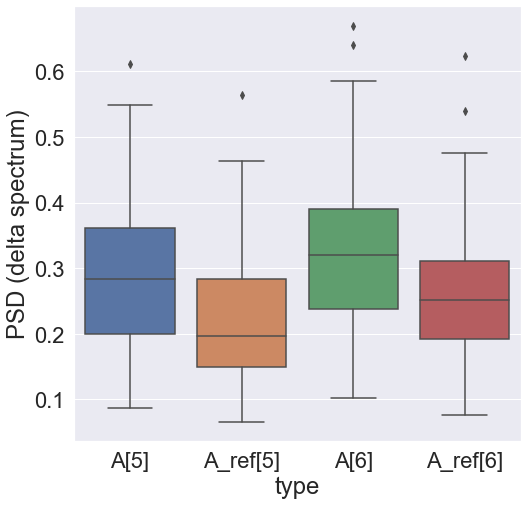

In [15]:
img = make_barplot(A_bandpass, A_ref_bandpass, [5, 6], 'A')

experiment.log_image(img, name='exp 1 (Speak), subj 1')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


{'web': 'https://www.comet.ml/api/image/download?imageId=383503b083b44035b2a9e291350bb32f&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=383503b083b44035b2a9e291350bb32f&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'imageId': '383503b083b44035b2a9e291350bb32f'}

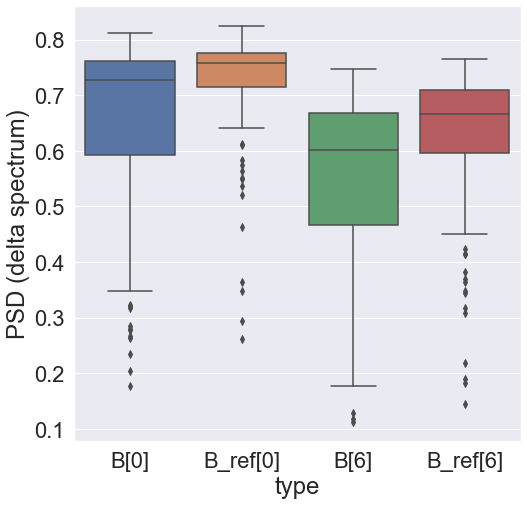

In [16]:
img = make_barplot(B_bandpass, B_ref_bandpass, [0, 6], 'B')

experiment.log_image(img, name='exp 1 (Speak), subj 2')

#### Experiment 2

In [17]:
exp_pair = [3,4]
A, A_ref, B, B_ref = get_data(exp_pair)

In [18]:
# size of the window is selected as a tradeoff between maximizing window time length
#  and maximizing the number of resulting windows to make the ANOVA analysis more confident.
# 500 samples = 2 sec at the sampling rate of 250 Hz.

A_bandpass     = rolling_window_psd(A, window=500, stride=500, sampling_freq=250)
A_ref_bandpass = rolling_window_psd(A_ref, window=500, stride=500, sampling_freq=250)
B_bandpass     = rolling_window_psd(B, window=500, stride=500, sampling_freq=250)
B_ref_bandpass = rolling_window_psd(B_ref, window=500, stride=500, sampling_freq=250)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


{'web': 'https://www.comet.ml/api/image/download?imageId=ce65f519ccec4c8b9e76fed4863c8711&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=ce65f519ccec4c8b9e76fed4863c8711&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'imageId': 'ce65f519ccec4c8b9e76fed4863c8711'}

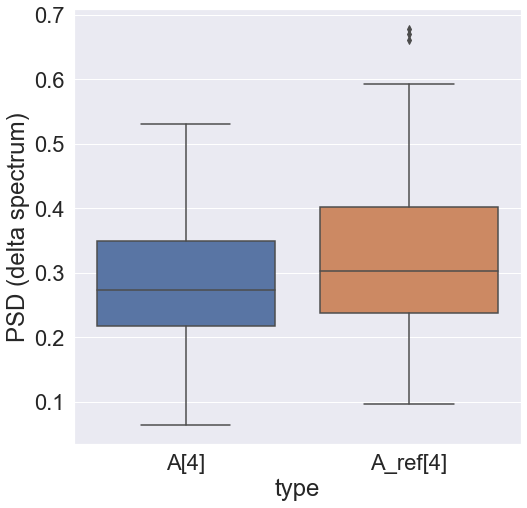

In [19]:
img = make_barplot(A_bandpass, A_ref_bandpass, [4], 'A')

experiment.log_image(img, name='exp 2 (Ping-Pong), subj 1')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


{'web': 'https://www.comet.ml/api/image/download?imageId=b234d859b405483380e77ac45c26fb9e&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=b234d859b405483380e77ac45c26fb9e&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'imageId': 'b234d859b405483380e77ac45c26fb9e'}

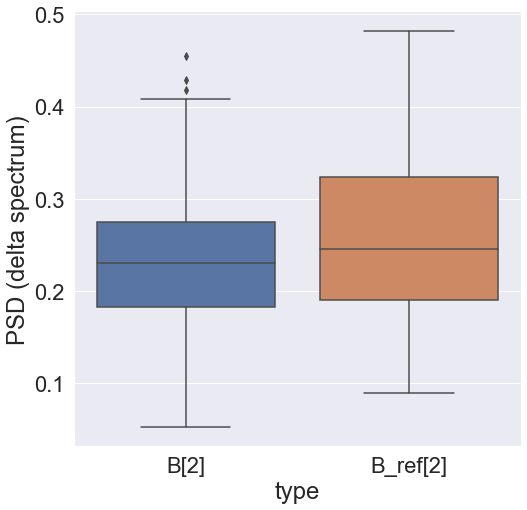

In [20]:
img = make_barplot(B_bandpass, B_ref_bandpass, [2], 'B')

experiment.log_image(img, name='exp 2 (Ping-Pong), subj 2')

#### Experiment 3

In [21]:
exp_pair = [5,7]
A, A_ref, B, B_ref = get_data(exp_pair)

In [22]:
# size of the window is selected as a tradeoff between maximizing window time length
#  and maximizing the number of resulting windows to make the ANOVA analysis more confident.
# 500 samples = 2 sec at the sampling rate of 250 Hz.

A_bandpass     = rolling_window_psd(A, window=500, stride=500, sampling_freq=250)
A_ref_bandpass = rolling_window_psd(A_ref, window=500, stride=500, sampling_freq=250)
B_bandpass     = rolling_window_psd(B, window=500, stride=500, sampling_freq=250)
B_ref_bandpass = rolling_window_psd(B_ref, window=500, stride=500, sampling_freq=250)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


{'web': 'https://www.comet.ml/api/image/download?imageId=531525a6f25245e3a87d6d88ea7a25ff&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=531525a6f25245e3a87d6d88ea7a25ff&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'imageId': '531525a6f25245e3a87d6d88ea7a25ff'}

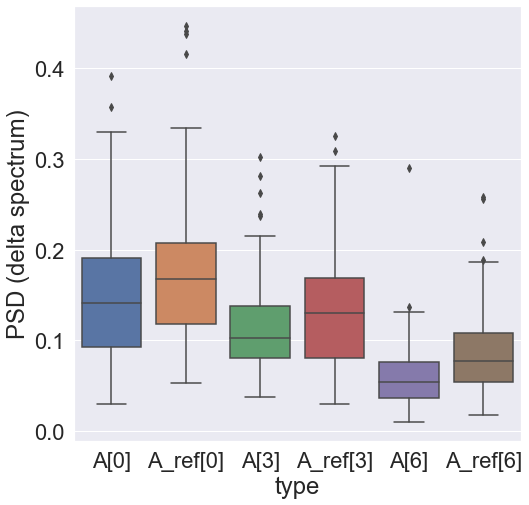

In [23]:
img = make_barplot(A_bandpass, A_ref_bandpass, [0,3,6], 'A')    # showing fewer of them, so that they fit in a figure

experiment.log_image(img, name='exp 3 (CS:GO comp), subj 1')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


{'web': 'https://www.comet.ml/api/image/download?imageId=23707ac4e4ea4259b10f11db6c615977&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=23707ac4e4ea4259b10f11db6c615977&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'imageId': '23707ac4e4ea4259b10f11db6c615977'}

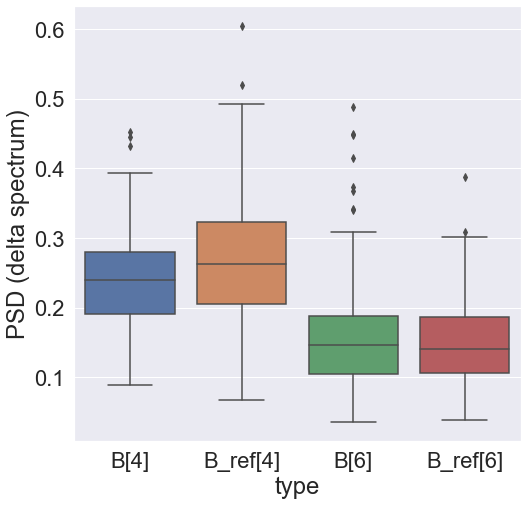

In [24]:
img = make_barplot(B_bandpass, B_ref_bandpass, [4,6], 'B')

experiment.log_image(img, name='exp 3 (CS:GO comp), subj 2')

#### Experiment 4

In [25]:
exp_pair = [6,7]
A, A_ref, B, B_ref = get_data(exp_pair)

In [26]:
# size of the window is selected as a tradeoff between maximizing window time length
#  and maximizing the number of resulting windows to make the ANOVA analysis more confident.
# 500 samples = 2 sec at the sampling rate of 250 Hz.

A_bandpass     = rolling_window_psd(A, window=500, stride=500, sampling_freq=250)
A_ref_bandpass = rolling_window_psd(A_ref, window=500, stride=500, sampling_freq=250)
B_bandpass     = rolling_window_psd(B, window=500, stride=500, sampling_freq=250)
B_ref_bandpass = rolling_window_psd(B_ref, window=500, stride=500, sampling_freq=250)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


{'web': 'https://www.comet.ml/api/image/download?imageId=90a9964fd7594ede921ae41beec00813&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=90a9964fd7594ede921ae41beec00813&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'imageId': '90a9964fd7594ede921ae41beec00813'}

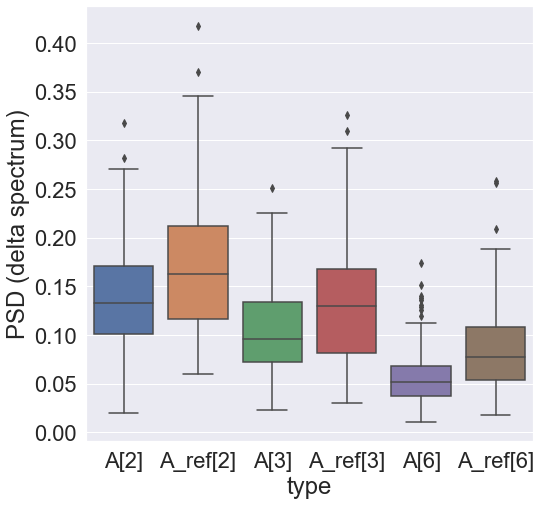

In [27]:
img = make_barplot(A_bandpass, A_ref_bandpass, [2,3,6], 'A')

experiment.log_image(img, name='exp 4 (CS:GO coop), subj 1')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


{'web': 'https://www.comet.ml/api/image/download?imageId=9784fa7cb8e0462f9f3c87df0f155db0&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=9784fa7cb8e0462f9f3c87df0f155db0&experimentKey=322050b2e5cc4c21a414dd7dd03d50be',
 'imageId': '9784fa7cb8e0462f9f3c87df0f155db0'}

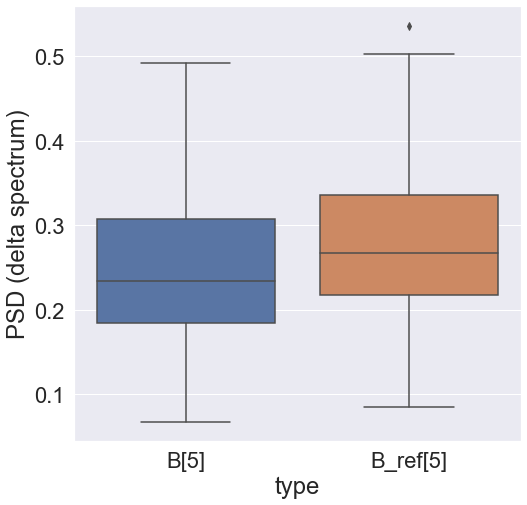

In [28]:
img = make_barplot(B_bandpass, B_ref_bandpass, [5], 'B')

experiment.log_image(img, name='exp 4 (CS:GO coop), subj 2')